In [1]:
import os
import glob
from functools import reduce

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats
import operator 

# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

# Statistical Analysis
---

In [3]:
# Constants

np.random.seed(seed=1)

# - Leafs
numLeafs = 1056
numPhyHostsPerLeaf = 48
maxVMsPerPhyHost = 20

# - Tenants
numTenants = 200
minVMsPerTenant = 10
maxVMsPerTenant = 5000

# - Groups
numGroups = 1000
minGroupSize = 5

In [4]:
# Leafs to physical host mapping
leafToPhyHostMap = []

for i in range(numLeafs):
    leafToPhyHostMap += [pd.Series([(i * numPhyHostsPerLeaf) + j for j in range(numPhyHostsPerLeaf)])]

In [5]:
# Phyical hosts to leaf mapping
phyHostToLeafList = []
for i in range(numLeafs):
    phyHostToLeafList += [i for _ in range(numPhyHostsPerLeaf)]

phyHostToLeafMap = pd.Series(phyHostToLeafList)

In [6]:
# Tenants
tenantsParams = {}

In [7]:
# Number of VMs per tenant
avgVMsPerTenant = 1.0 * (maxVMsPerPhyHost * (numLeafs * numPhyHostsPerLeaf)) / numTenants
tenantsParams['VMs'] = pd.Series(stats.geom.rvs(size=numTenants, 
                                                loc=minVMsPerTenant, p=1.0/avgVMsPerTenant)) 
                       # using geometric distribution as discrete exponential distribution
# tenantsParams['VMs'] = pd.Series(np.int64(((stats.expon.rvs(size=numTenants, scale=(1.0 / 2)) / 10) 
#                                            * (maxVMsPerTenant - minVMsPerTenant))
#                                           % (maxVMsPerTenant - minVMsPerTenant) + minVMsPerTenant))

In [8]:
tenantsParams['VMs'].describe()

count      200.000000
mean      4984.280000
std       5051.607663
min         11.000000
25%       1153.750000
50%       3838.500000
75%       6984.250000
max      30030.000000
dtype: float64

In [9]:
# Number of groups per tenant
tenantsParams['Groups'] = pd.Series(np.int64(np.floor((tenantsParams['VMs'] / sum(tenantsParams['VMs'])) 
                                                      * numGroups)))
# sns.kdeplot(tenants['Groups'], cumulative=True)

In [10]:
tenantsParams['Groups'].describe()

count    200.000000
mean       4.530000
std        5.075223
min        0.000000
25%        1.000000
50%        3.000000
75%        7.000000
max       30.000000
dtype: float64

In [11]:
# Size of each group in a tenant. Also do it using WVE distribution.
tenantsParams['GroupSizes'] = []
for i in range(numTenants):
    tenantsParams['GroupSizes'] += [pd.Series(stats.randint.rvs(low=minGroupSize, 
                                                                high=tenantsParams['VMs'][i], 
                                                                size=tenantsParams['Groups'][i]))]

In [12]:
# Tenants' groups to VM mapping
tenantsGroupToVMMap = []

for i in range(numTenants):
    temp_list = []
    for j in range(tenantsParams['Groups'][i]):
        temp_list += [pd.Series(stats.randint.rvs(low=0,
                                                  high=tenantsParams['VMs'][i], 
                                                  size=tenantsParams['GroupSizes'][i][j]))]
    tenantsGroupToVMMap += [temp_list]

In [13]:
# Tenants' VMs to physical host mapping using uniform random distribution. 
# Also, do it for coloacated hosts under same leaf.
tenantsVMToPhyHostMap = []

for i in range(numTenants):
    tenantsVMToPhyHostMap += [pd.Series(np.random.choice(a=(numLeafs * numPhyHostsPerLeaf), 
                                                         size=tenantsParams['VMs'][i], 
                                                         replace=False))]

In [14]:
# To ask ... how do we pick so that no host has more than 20 VMs

In [15]:
# hostVMCount = []
# for i in range(numLeafs * numPhyHostsPerLeaf):
#     hostVMCount += [0]
#     for j in range(numTenants):
#         for k in range(tenantsParams['VMs'][j]):
#             if tenantsVMToPhyHostMap[j][k] == i:
#                 hostVMCount[i] += 1

In [16]:
# pd.Series(hostVMCount).describe()

In [17]:
# Tenants' groups to leaf mapping
tenantsGroupToLeafMap = []

for i in range(numTenants):
    temp_list = []
    for j in range(tenantsParams['Groups'][i]):
        temp_list += [pd.Series([phyHostToLeafMap[tenantsVMToPhyHostMap[i][value]]
                                 for _, value in tenantsGroupToVMMap[i][j].iteritems()])]
    tenantsGroupToLeafMap += [temp_list]

In [18]:
# Tenants' groups to unique leaf count (i.e., the spread of a group across leafs)
tenantsGroupToUniqueLeafCount = []

for i in range(numTenants):
    temp_list = []
    for j in range(tenantsParams['Groups'][i]):
        temp_list += [len(tenantsGroupToLeafMap[i][j].unique())]
    tenantsGroupToUniqueLeafCount += [temp_list]

In [19]:
# Distribution of leaf spread for each group in all tenants.
plot_tenantsGroupLeafSpread = pd.Series(reduce(operator.add, 
                                               [tenantsGroupToUniqueLeafCount[i] for i in range(numTenants)]))

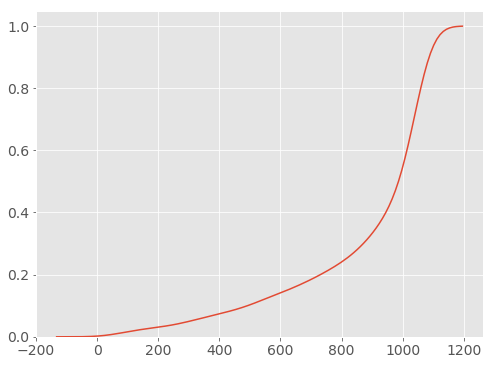

In [20]:
sns.kdeplot(plot_tenantsGroupLeafSpread, cumulative=True)

In [21]:
plot_tenantsGroupLeafSpread.describe()

count     906.000000
mean      884.402870
std       246.333018
min         7.000000
25%       820.500000
50%      1008.500000
75%      1052.000000
max      1056.000000
dtype: float64

# Others
---

### Maximum number of members supported when located under 'n' ToR switches

A typical ToR switch connected to 48 servers. Thus, if member VMs of a tenants are co-located under 'n' ToRs, where 'n' is the number of bitmaps available, then the following analysis shows the maximum numbers of members supported per group (or topic):

Assumption:
- A tenant’s VMs do not share the same physical host for reasons of resilience etc.

Given:
- 48 servers under a ToR
- n is the number of bitmaps
- width of a bitmap is equal to the number of servers connected to a ToR switch (i.e., 48 in this case)

In [9]:
plot_data = pd.DataFrame()

bitmap_size = 48
num_bitmap_list = [1, 2, 4, 8, 16, 32]

member_list = []
header_size_list = []
for num_bitmap in num_bitmap_list:
    member_list += [(num_bitmap * bitmap_size)]
    header_size_list += [(num_bitmap * bitmap_size)]

plot_data['No. of Bitmaps'] = num_bitmap_list
plot_data['No. of Hosts'] = member_list
plot_data['Header Size (in bits)'] = header_size_list
plot_data = plot_data.set_index('No. of Bitmaps')

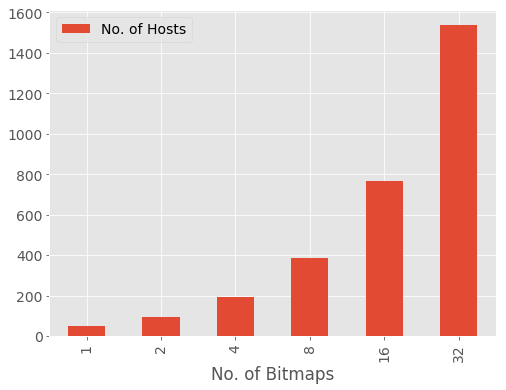

In [10]:
plot_data[['No. of Hosts']].plot(kind='bar')

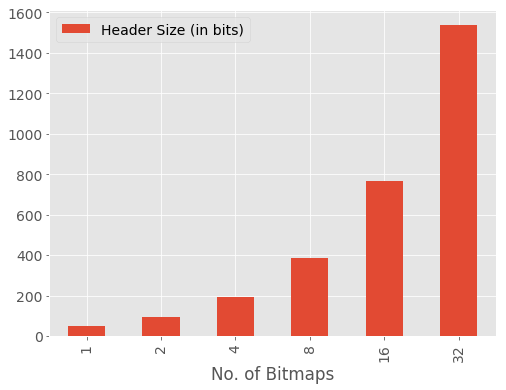

In [11]:
plot_data[['Header Size (in bits)']].plot(kind='bar')

This shows that using only 16 bitmaps (48 bit wide), we can handle groups sizes of about 512 members.

From Figure 4, in the SDN IP multicast paper, we can see that this allows us to handle about 80% of the groups, in the case of WVE distribution, and 60% of the groups, in case of uniform distribution, without requiring any group entries in the network switches.